In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics import silhouette_score, adjusted_rand_score

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


66219


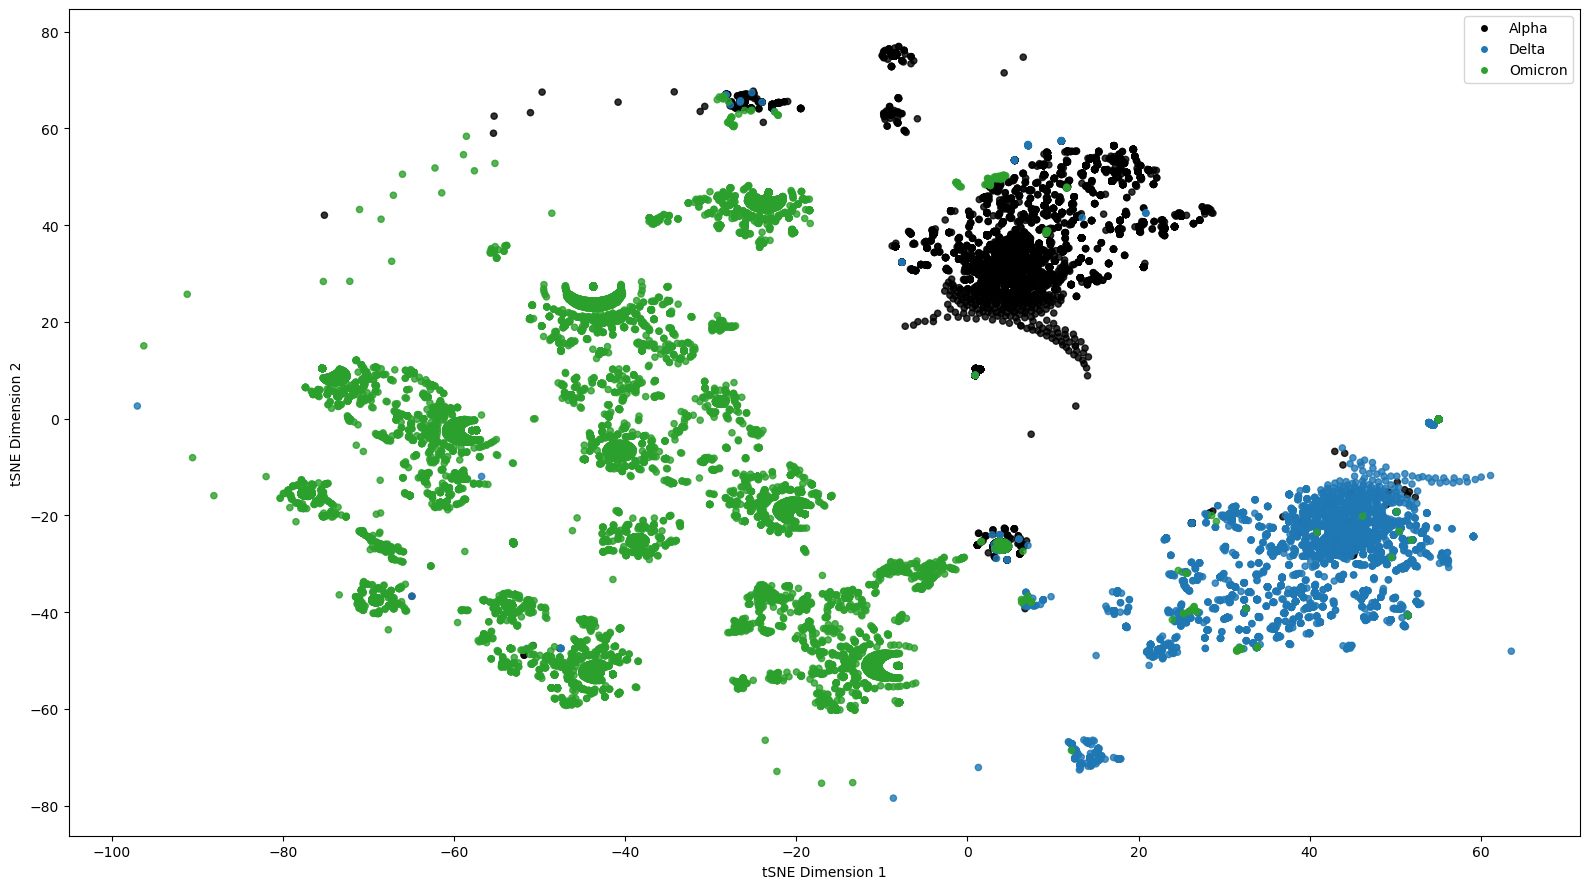

In [2]:
def plot_variant_from_embedding(csv_file, type):
    df = pd.read_csv(csv_file, sep=',', header=0)
    print(len(df))

    # Custom color mapping for specified variants
    cmap = {'Alpha': 'black', 
            'Delta': 'tab:blue', 
            'Omicron': 'tab:green'}
    
    variant_labels = sorted(df["variant"].unique())
    variant_colors = {}
    for variant in variant_labels:
        if variant in cmap:
            variant_colors[variant] = cmap[variant]

    df['colors'] = [variant_colors[variant] for variant in df['variant']]

    # Legend handles
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_colors[variant], label=variant) for variant in variant_labels]

    # Create a scatter plot
    plt.figure(figsize=(16,9))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.scatter(df['DIM_1'], df['DIM_2'], c=df['colors'], s=20, alpha=0.8)
    plt.xlabel(f'{type} Dimension 1')
    plt.ylabel(f'{type} Dimension 2')
    plt.legend(handles=legend_handles)
    plt.tight_layout()
    plt.show()
    #plt.savefig(csv_file.replace('_coordinates.csv', '_plot.pdf'), format='pdf')

old_run_dir = '../Spike_NLP_kaetlyn/results/run_results1/clustering/plot_rbd_cluster-2024-02-26_10-25'
tsne_list = os.path.join(old_run_dir, f"rbd_variants_clustering_esm_blstm_a22073_d22073_o22073_iter0_tsne_coordinates.csv")
plot_variant_from_embedding(tsne_list, 'tSNE', )

In [3]:
def plot_hdbscan(save_as, info_df, embedding_matrix, hdb_labels, data_column):
    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette("tab20", n_colors=len(unique_clusters) - 1)
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    # Define marker shapes
    markers = ['o', '^', 's']  # Add more shapes if needed
    n_markers = len(markers)

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

    # HDBSCAN clusters
    plt.figure(figsize=(16, 14))

    for i, label in enumerate(unique_clusters):
        mask = hdb_labels == label
        marker = markers[i // 20 % n_markers]  # Change shape after every 20 colors (tab20 has 20 colors)
        if label == -1:
            plt.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=15)
        else:
            plt.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=50, alpha=0.7, edgecolors='k', marker=marker)

    fontsize = 16
    plt.title(f'Predicted: {n_predicted_clusters} clusters', fontsize=fontsize+2)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.xlabel('Component 1', fontsize=fontsize)
    plt.ylabel('Component 2', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()


def plot_hdbscan_comparison(save_as, info_df, embedding_matrix, hdb_labels, data_column):
    # Color map for ground truth
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette("tab20", n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette("tab20", n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters
    ax1 = axes[0]
    ax1.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                       c='black', label='Outliers', marker='x', s=35)
        else:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                       c=[cluster_color_dict[label]], label=f'Cluster {label}',
                       s=40, alpha=0.8, edgecolors='k')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Right subplot: Ground truth
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for value in unique_data_values:
        mask = info_df[data_column] == value
        ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[ground_truth_color_dict[value]], label=value,
                    s=50, alpha=0.8, edgecolors='k')

    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=14)
        ax.set_ylabel('Component 2', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()

def plot_hdbscan_comparison_ado(save_as, info_df, embedding_matrix, hdb_labels, data_column):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Custom color mapping for specified variants
    cmap = {'Alpha': 'black', 
            'Delta': 'tab:blue', 
            'Omicron': 'tab:green'}
    
    variant_labels = sorted(info_df[data_column].unique())
    variant_colors = {}
    
    # Assign colors based on the custom color map (cmap)
    for variant in variant_labels:
        if variant in cmap:
            variant_colors[variant] = cmap[variant]
        else:
            # Dynamically assign a color if the variant isn't in the cmap
            variant_colors[variant] = sns.color_palette("tab20", n_colors=len(variant_labels))[variant_labels.index(variant)]

    # Add the color mapping to the dataframe
    info_df['colors'] = [variant_colors[variant] for variant in info_df[data_column]]

    # HDBSCAN cluster color mapping
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette("tab10", n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(variant_labels)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters
    ax1 = axes[0]
    ax1.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=35)
        else:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=40, alpha=0.8, edgecolors='k')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Right subplot: Ground truth with custom variant colors
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for variant in variant_labels:
        mask = info_df[data_column] == variant
        ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[variant_colors[variant]], label=variant,
                    s=50, alpha=0.8, edgecolors='k')

    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=14)
        ax.set_ylabel('Component 2', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()


def plot_hdbscan_with_groups(save_as, info_df, embedding_matrix, hdb_labels, data_column, group_column):
    """
    Plots HDBSCAN clusters and ground truth with different shapes for group_column values, 
    including a unified legend for Serotypes and Groups with subtitles.
    
    Args:
    - info_df: DataFrame containing metadata, including the 'data_column' (e.g., 'serotype') and 'group_column' (e.g., 'dataset', 'host').
    - embedding_matrix: The 2D embedding (e.g., UMAP, t-SNE).
    - hdb_labels: Cluster labels from HDBSCAN, with -1 for outliers.
    - data_column: Column name in info_df for color coding (e.g., 'serotype').
    - group_column: Column name in info_df for differentiating groups (e.g., 'dataset', 'host').
    """
    # Color map for ground truth
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette("tab20", n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette("tab20", n_colors=len(unique_clusters) - 1)
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    # Marker shapes for different groups
    unique_groups = info_df[group_column].unique()
    markers = ['o', '^', 's', 'p', '*', 'D', 'v', 'P', '.']
    group_marker_dict = dict(zip(unique_groups, markers))

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters (Predicted)
    ax = axes[0]
    ax.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        for group in unique_groups:
            mask = (hdb_labels == label) & (info_df[group_column] == group)
            if label == -1:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c='black', label='Outliers', marker='x', s=35)
            else:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c=[cluster_color_dict[label]], marker=group_marker_dict[group],
                           label=f'Cluster {label} ({group})', s=30, alpha=0.8, edgecolors='k')

    legend_handles_predicted = []
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='x', color='black', linestyle='none', markersize=7, label='Outliers'))
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[label], markersize=10, label=f'Cluster {label}')
        for label in unique_clusters if label != -1
    ]
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    # Right subplot: Ground truth
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for value in unique_data_values:
        for group in unique_groups:
            mask = (info_df[data_column] == value) & (info_df[group_column] == group)
            ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[ground_truth_color_dict[value]], marker=group_marker_dict[group],
                        label=f'{value} ({group})', s=20, alpha=0.8, edgecolors='k')

    legend_handles_ground_truth = []    
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ground_truth_color_dict[value], markersize=10, label=value)
        for value in unique_data_values
    ]
    legend_handles_ground_truth.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=14)
        ax.set_ylabel('Component 2', fontsize=14)

    axes[0].legend(handles=legend_handles_predicted, loc='upper right', bbox_to_anchor=(1.2, 1))
    axes[1].legend(handles=legend_handles_ground_truth, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()

In [4]:
df = pd.read_csv(tsne_list, sep=',', header=0)

meta_data = "./data/RBD/spikeprot0528.clean.uniq.noX.RBD.metadata.tsv"
metadata_df = pd.read_csv(meta_data, sep='\t', header=0, low_memory=False)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})
metadata_df = metadata_df[['seq_id', 'Pango lineage', 'Location', 'Collection date', 'AA Substitutions']]
merged_df = pd.merge(df, metadata_df, on='seq_id', how='left')

print(merged_df['variant'].value_counts())
merged_df.head(5)

variant
Alpha      22073
Delta      22073
Omicron    22073
Name: count, dtype: int64


,seq_id,variant,DIM_1,DIM_2,Pango lineage,Location,Collection date,AA Substitutions
0,EPI_ISL_2305967,Alpha,6.189471,33.035965,B.1.1.7,North America / USA / North Carolina,2021-05-09,"(Spike_H69del,NS8_Q27stop,NSP3_T183I,Spike_G14..."
1,EPI_ISL_1572917,Alpha,18.072947,53.245296,B.1.1.7,Europe / Germany / Bavaria,2021-03-31,"(Spike_H69del,NS8_Q27stop,NSP3_T183I,Spike_T71..."
2,EPI_ISL_1247622,Alpha,4.350025,35.653350,B.1.1.7,Europe / United Kingdom / England,2021-03-06,"(NSP2_D449E,Spike_H69del,NS8_Q27stop,NS7a_R80T..."
3,EPI_ISL_2370551,Alpha,8.425841,52.706833,B.1.1.7,Europe / Greece / Attica,2021-04-20,"(Spike_H69del,NS8_Q27stop,Spike_G413R,NSP3_T18..."
4,EPI_ISL_1369514,Alpha,5.561197,33.953190,B.1.1.7,Europe / Switzerland / Geneva,2021-03-13,"(Spike_H69del,NS8_Q27stop,NSP10_T12I,NSP3_T183..."


In [5]:
info_df = merged_df.drop(columns=['DIM_1', 'DIM_2'])
embedding_matrix_reduced = np.array(merged_df[['DIM_1', 'DIM_2']].values.tolist(), dtype=np.float32)
embedding_matrix_reduced

array([[  6.1894712,  33.035965 ],
       [ 18.072947 ,  53.245296 ],
       [  4.350025 ,  35.65335  ],
       ...,
       [-21.740541 , -37.261444 ],
       [-36.867474 ,  40.23037  ],
       [-22.526037 , -53.523846 ]], dtype=float32)

In [8]:
for i in [5, 10, 15, 20, 25, 30, 35]:
    for j in [15000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 15000: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.86)
min_sample 10, min_cluster_size 15000: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.88)
min_sample 15, min_cluster_size 15000: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.88)
min_sample 20, min_cluster_size 15000: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.88)
min_sample 25, min_cluster_size 15000: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.88)
min_sample 30, min_cluster_size 15000: (Silhouette Coefficient 0.54, Adjusted Rand Index 0.88)
min_sample 35, min_cluster_size 15000: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.89)


In [7]:
for i in [35]:
    for j in [18000, 18500, 19000, 19500, 20000, 21000, 22000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 35, min_cluster_size 18000: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.89)
min_sample 35, min_cluster_size 18500: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.89)
min_sample 35, min_cluster_size 19000: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.89)
min_sample 35, min_cluster_size 19500: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.89)
min_sample 35, min_cluster_size 20000: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.89)
min_sample 35, min_cluster_size 21000: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.55)
min_sample 35, min_cluster_size 22000: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.55)


min_sample 35, min_cluster_size 20000: Silhouette Coefficient: 0.49, Adjusted Rand Index: 0.89


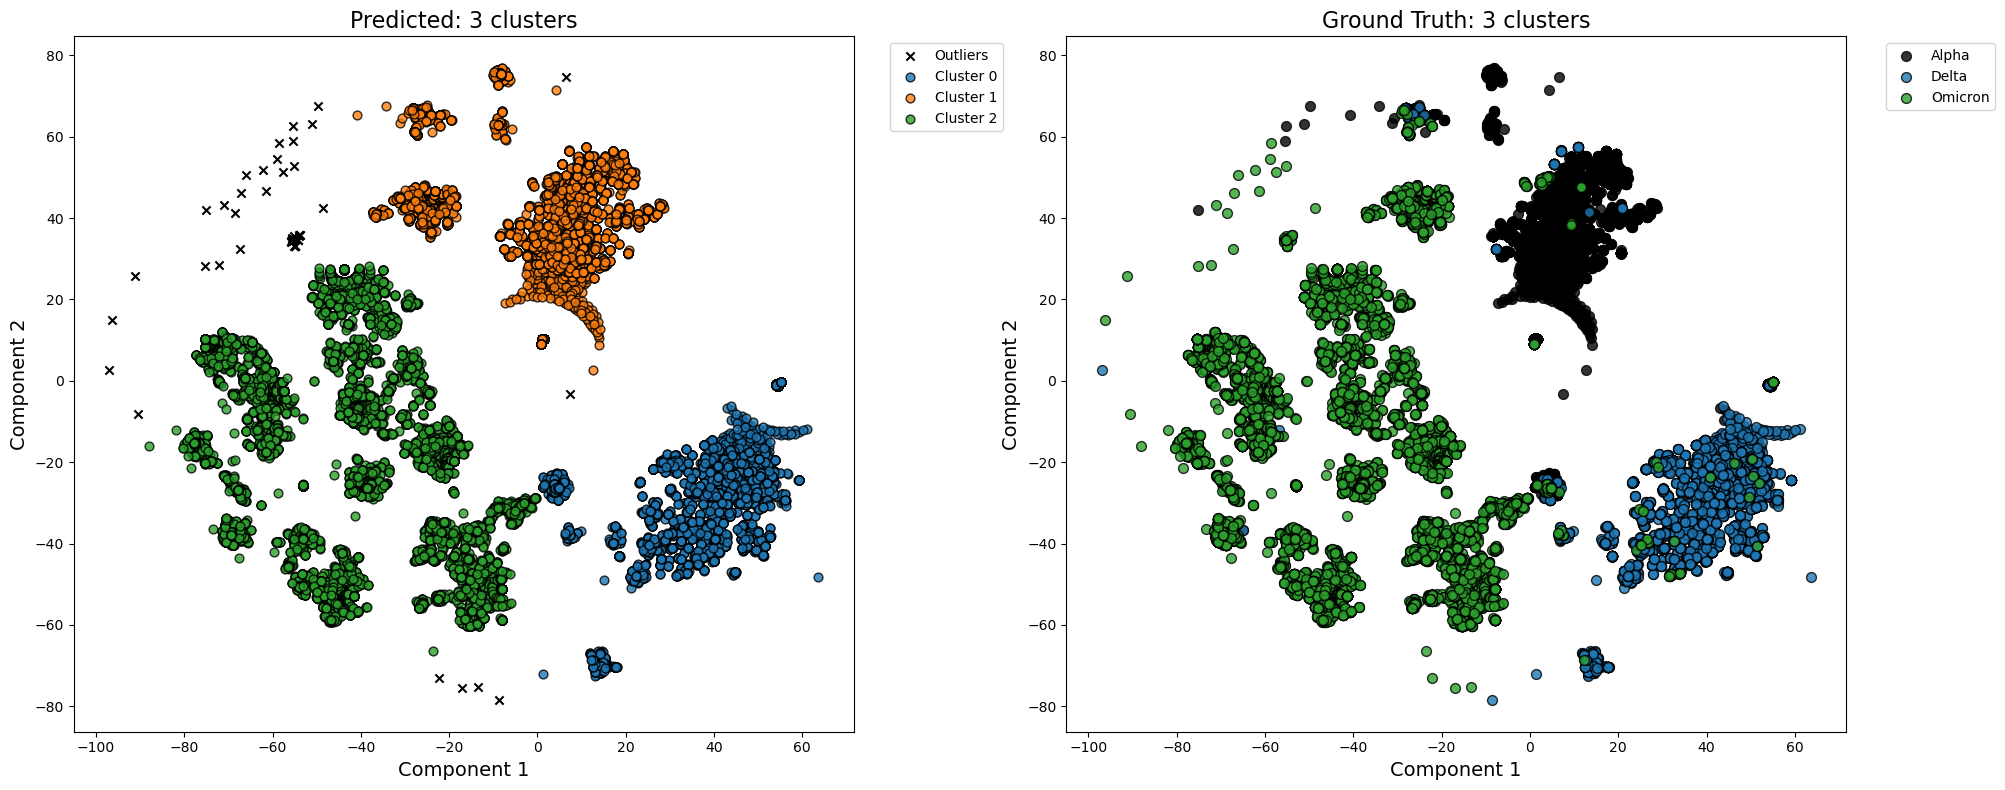

In [9]:
min_samples=35
min_cluster_size=20000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"./plots/rbd_ado-tsne_hdbscan-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg}_ari{ari}"
plot_hdbscan_comparison_ado(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant")

Too high results in poorer scores and worse prediction.

min_sample 40, min_cluster_size 20000: Silhouette Coefficient: 0.41, Adjusted Rand Index: 0.55


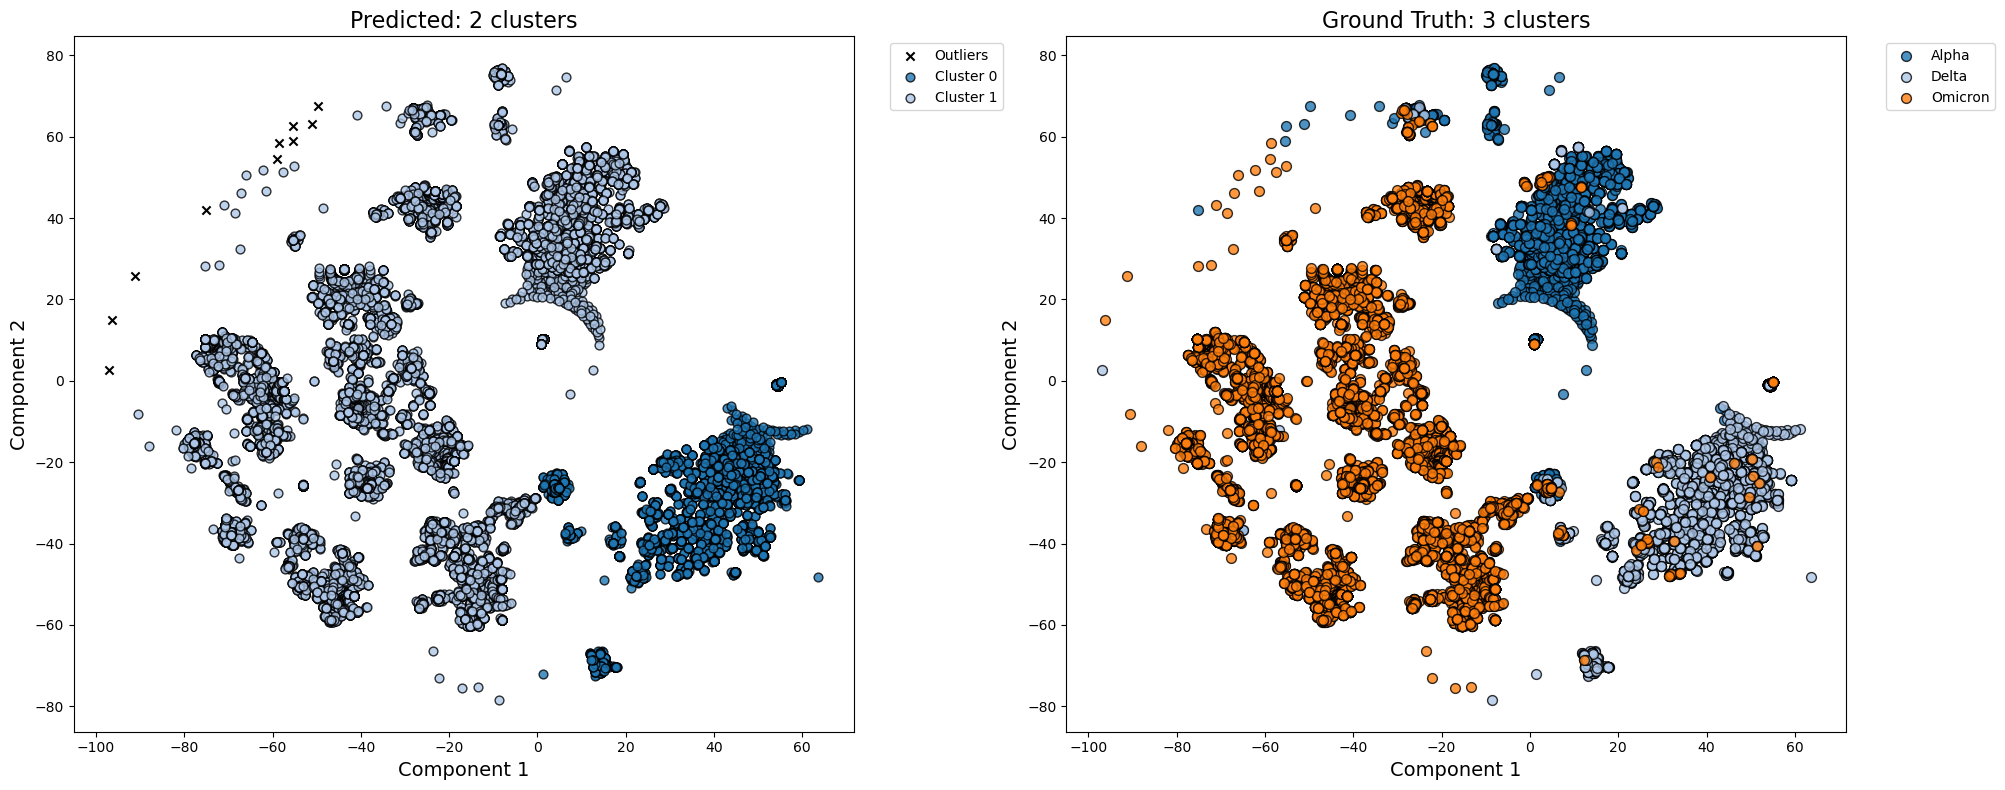

In [10]:
min_samples=40
min_cluster_size=20000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"./plots/rbd_ado-tsne_hdbscan-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg}_ari{ari}"
plot_hdbscan_comparison(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant")

---

### Clustering based on pango lineage

In [9]:
for i in [5, 10, 15, 20, 25, 30, 35]:
    for j in [5, 25, 50, 100, 200]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["Pango lineage"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 5: (Silhouette Coefficient 0.75, Adjusted Rand Index 0.43)
min_sample 5, min_cluster_size 25: (Silhouette Coefficient 0.71, Adjusted Rand Index 0.43)
min_sample 5, min_cluster_size 50: (Silhouette Coefficient 0.70, Adjusted Rand Index 0.44)
min_sample 5, min_cluster_size 100: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.43)
min_sample 5, min_cluster_size 200: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.45)
min_sample 10, min_cluster_size 5: (Silhouette Coefficient 0.70, Adjusted Rand Index 0.42)
min_sample 10, min_cluster_size 25: (Silhouette Coefficient 0.69, Adjusted Rand Index 0.43)
min_sample 10, min_cluster_size 50: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.43)
min_sample 10, min_cluster_size 100: (Silhouette Coefficient 0.69, Adjusted Rand Index 0.43)
min_sample 10, min_cluster_size 200: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.46)
min_sample 15, min_cluster_size 5: (Silhouette Coefficient 0.68, Adjusted Rand Inde

In [10]:
for i in [10, 20, 30, 40, 50]:
    for j in [195]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["Pango lineage"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 10, min_cluster_size 195: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.47)
min_sample 20, min_cluster_size 195: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.46)
min_sample 30, min_cluster_size 195: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.45)
min_sample 40, min_cluster_size 195: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.45)
min_sample 50, min_cluster_size 195: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.45)


min_sample 10, min_cluster_size 195: Silhouette Coefficient: 0.68, Adjusted Rand Index: 0.47


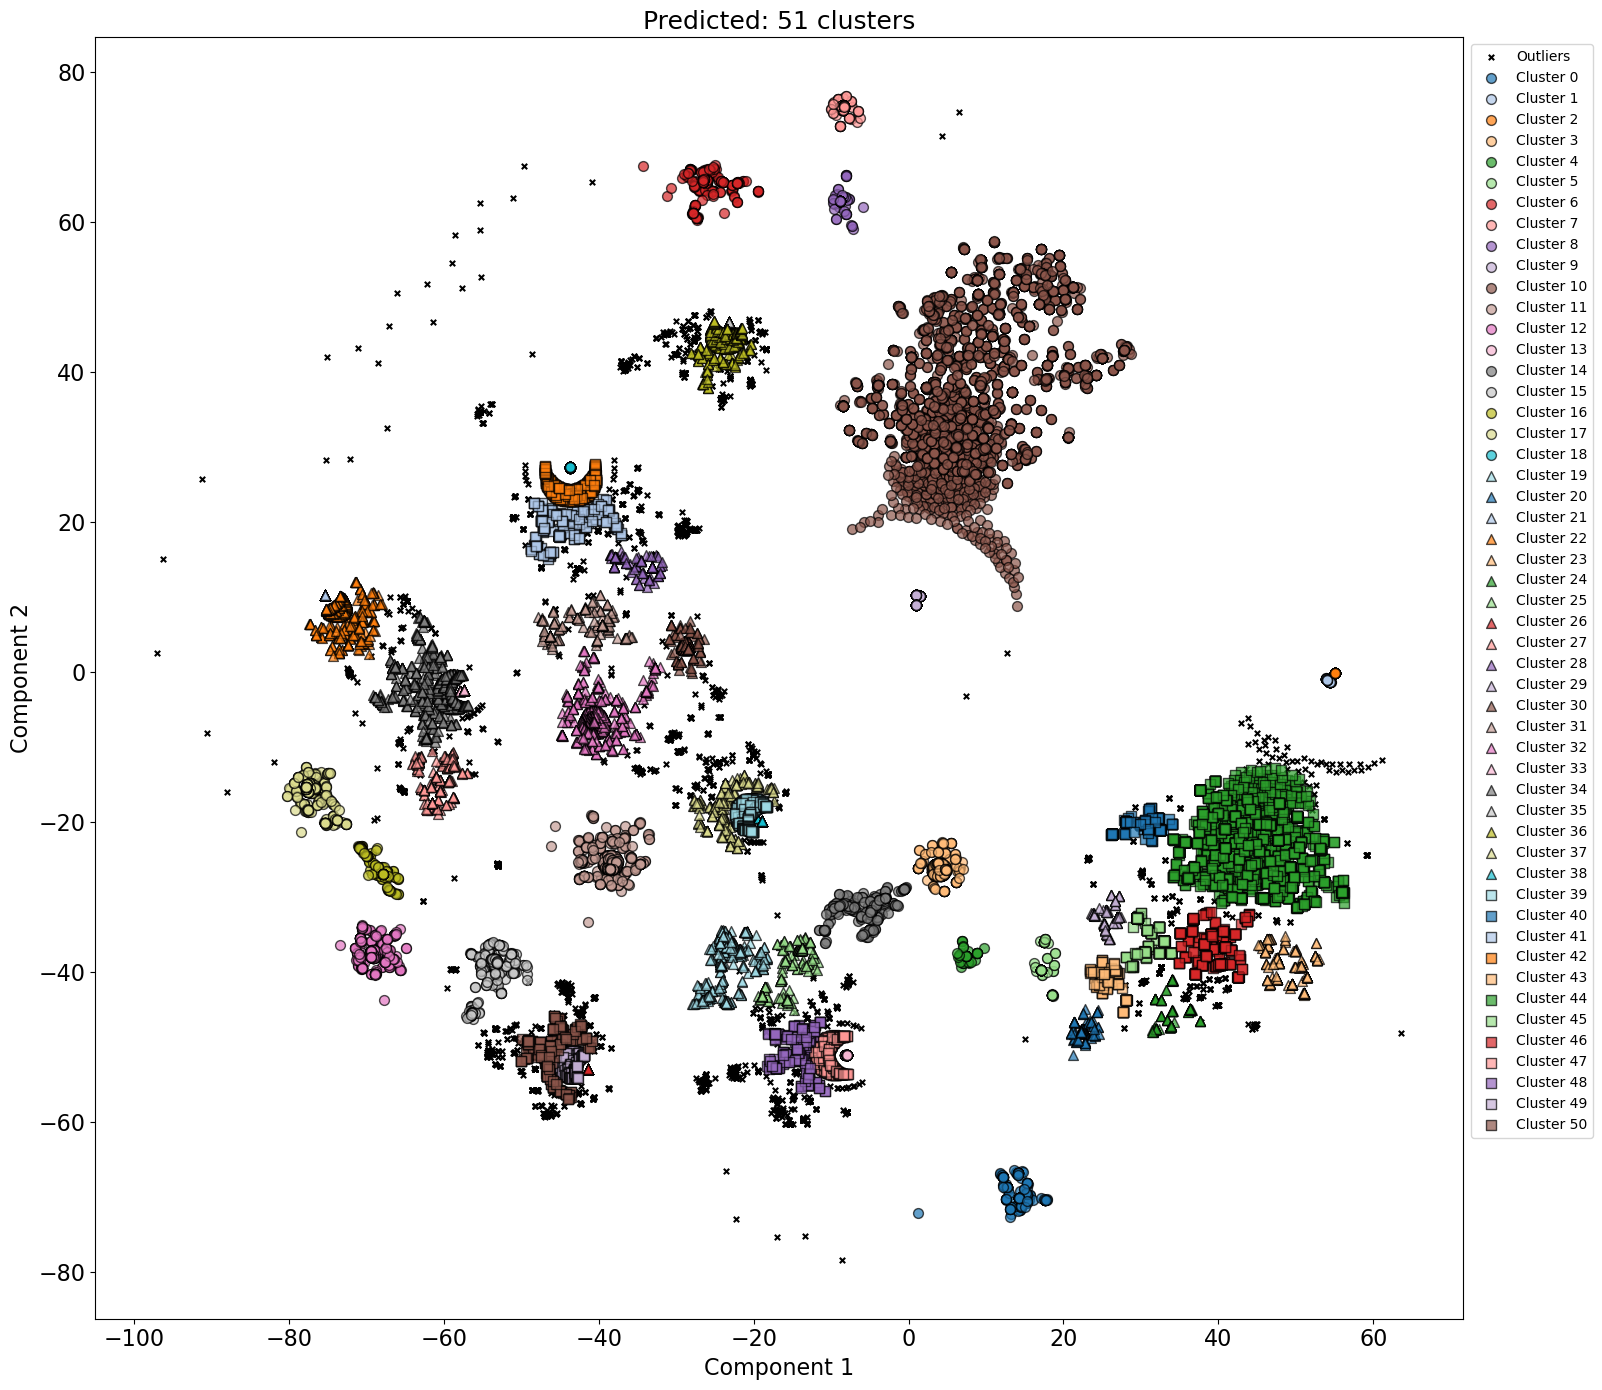

In [6]:
min_samples=10
min_cluster_size=195

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["Pango lineage"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"./plots/rbd_ado-tsne_hdbscan-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg}_ari{ari}"
plot_hdbscan(save_as, info_df, embedding_matrix_reduced, hdb_labels, "Pango lineage")

Let's take a look at the values in each cluster.

In [7]:
info_df['Cluster'] = hdb_labels
info_df["Pango lineage"].value_counts()

Pango lineage
B.1.1.7      21485
AY.4          2848
BA.2          1906
BA.1.1        1593
B.1.617.2     1583
             ...  
EK.2             1
DY.3             1
BA.5.2.63        1
BA.5.2.40        1
BF.33            1
Name: count, Length: 1167, dtype: int64

In [8]:
cluster_lineage_counts = info_df.groupby(['Cluster', 'variant', 'Pango lineage']).size().reset_index(name='Count')
cluster_lineage_counts = cluster_lineage_counts.sort_values(by=['Cluster', 'Count'], ascending=[True, False]).reset_index(drop=True)
cluster_lineage_counts

,Cluster,variant,Pango lineage,Count
0,-1,Omicron,BA.2,298
1,-1,Omicron,BA.1.1,180
2,-1,Omicron,XBB.1.5,172
3,-1,Omicron,BA.5.2,119
4,-1,Omicron,Unassigned,96
...,...,...,...,...
3983,50,Omicron,XBB.1.5.21,1
3984,50,Omicron,XBB.1.5.38,1
3985,50,Omicron,XBB.1.5.8,1
3986,50,Omicron,XBB.3,1


In [11]:
import pandas as pd

def cluster_pango_lineage(info_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])
    lineage_counts = lineage_counts.drop(columns=['Cluster count', 'Total count'])

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

# Example usage:
result = cluster_pango_lineage(info_df, 5)

# Export to CSV
result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)
result

,Cluster,variant,Pango lineage,Cluster %,Lineage %
0,-1,Omicron,BA.5.2*,9.431280,18.123862
1,-1,Omicron,BA.2,7.061611,15.634837
2,-1,Omicron,BQ.1.1*,7.014218,21.142857
3,-1,Omicron,XBB.1.5*,5.734597,21.415929
4,-1,Omicron,BA.1.1*,5.118483,11.374408
...,...,...,...,...,...
250,50,Omicron,XBB.1.5*,69.767442,18.584071
251,50,Omicron,XBB.1.9*,7.308970,13.580247
252,50,Omicron,Unassigned,4.983389,1.666667
253,50,Omicron,XBB.1,3.322259,6.060606


In [12]:
import pandas as pd

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

# Example usage:
clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron       BA.5.2*   9.431280  18.123862
1       -1  Omicron          BA.2   7.061611  15.634837
2       -1  Omicron       BQ.1.1*   7.014218  21.142857
3       -1  Omicron      XBB.1.5*   5.734597  21.415929
4       -1  Omicron       BA.1.1*   5.118483  11.374408

   Cluster variant Pango lineage  Cluster %  Lineage %
0        0   Delta      B.1.617*  10.679612   2.779533
1        0   Delta        AY.127   6.310680  10.441767
2        0   Delta        AY.122   5.825243   1.635992
3        0   Delta         AY.36   5.825243  21.238938
4        0   Delta     AY.112.2*   5.339806  95.652174

   Cluster variant Pango lineage  Cluster %  Lineage %
0        1   Delta          AY.4  14.624506   1.299157
1        1   Delta        AY.122   7.905138   1.363327
2        1   Delta      B.1.617*   7.905138   1.263424
3        1   Delta         AY.44   6.719368   1.772680
4        1   Delta        AY.103   5.138340   1.101695

 

- Cluster %: The percentage of a specific Pango lineage within a particular cluster, calculated as the number of occurrences of that lineage in the cluster divided by the total number of occurrences of all lineages in the cluster.
- Lineage %: The percentage of a specific Pango lineage's occurrences in a cluster relative to its total occurrences across the entire dataset.

Maybe better names would be Lineage Cluster %, Lineage Dataset %?

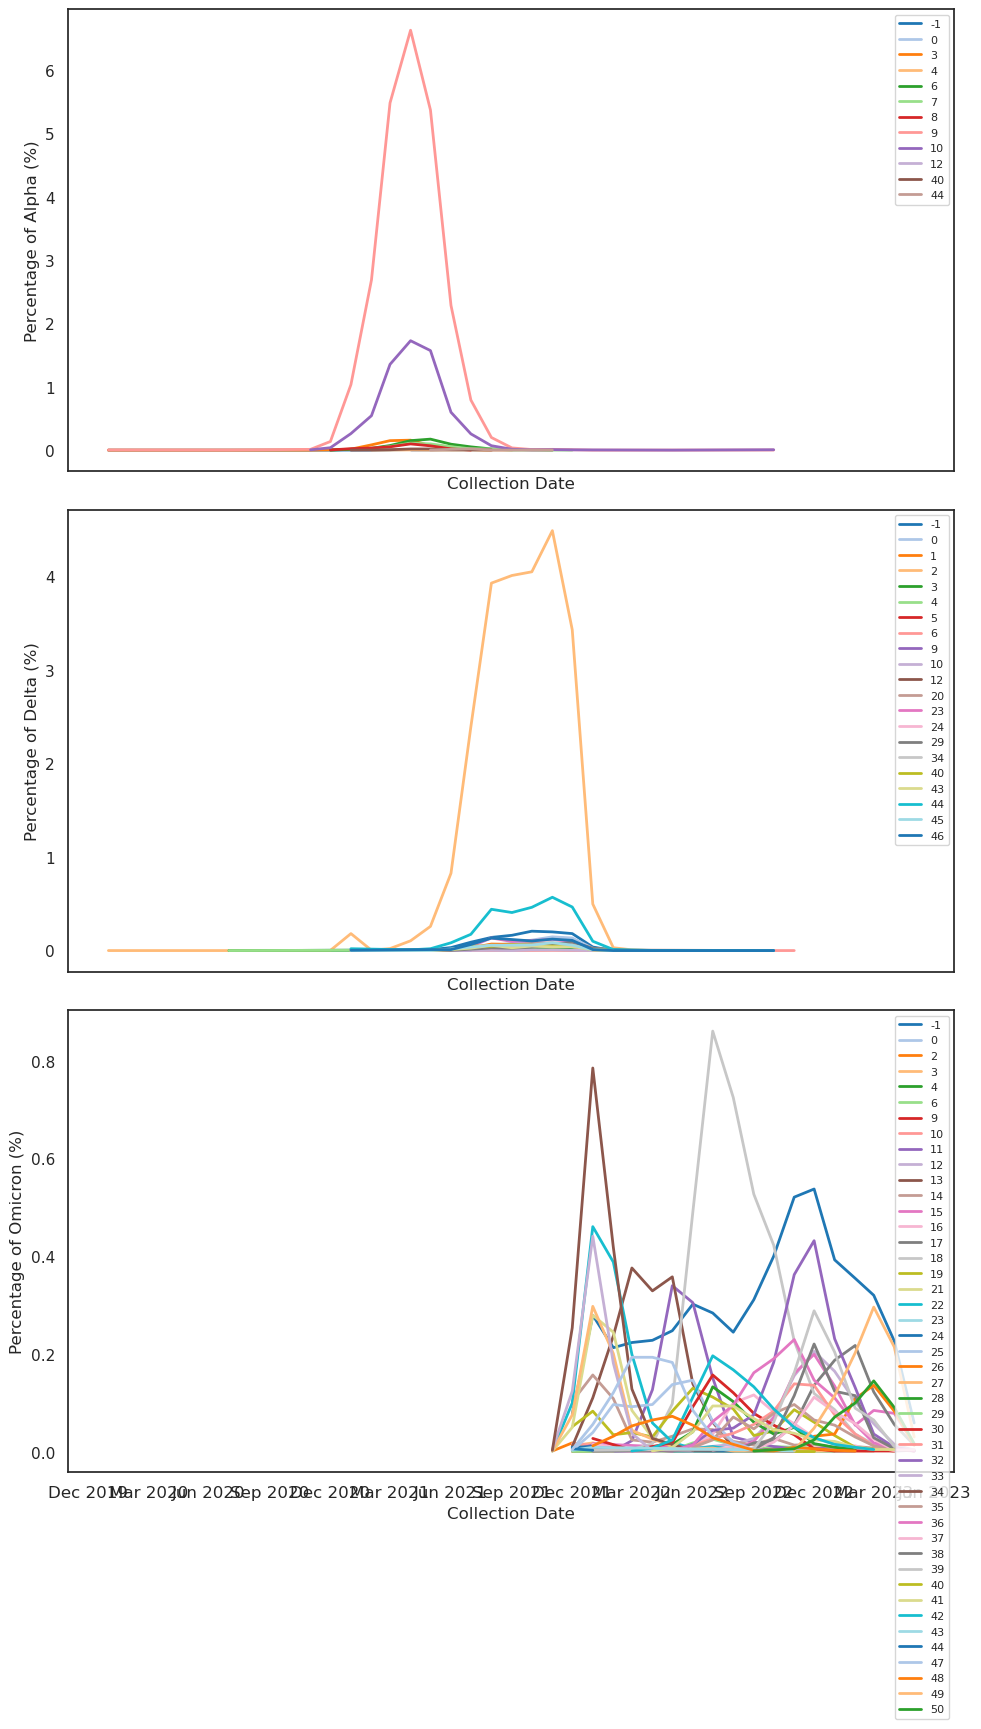

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def cluster_date_collected(info_df):
    """ Calculate variant percentages over collection dates within clusters and split into multiple plots. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Ensure 'Collection date' is a datetime object
    df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

    # Aggregate data by counting variants for each collection date (by year and month)
    df['YearMonth'] = df['Collection date'].dt.to_period('M')
    cluster_date_counts = df.groupby(['Cluster', 'YearMonth', 'variant']).size().reset_index(name='Cluster count')

    # Calculate grand total count across the entire dataset
    grand_total_count = df.groupby(['YearMonth', 'variant']).size().sum()

    # Calculate percentages within each cluster
    cluster_date_counts['Cluster %'] = (cluster_date_counts['Cluster count'] / grand_total_count) * 100

    # Sort by 'Cluster' and 'YearMonth'
    cluster_date_counts = cluster_date_counts.sort_values(by=['Cluster', 'YearMonth'], ascending=[True, True])

    # Identify the unique variants
    variants = cluster_date_counts['variant'].unique()

    # Create 3 subplots (3 rows, 1 column)
    sns.set_theme(style="white")
    sns.set_palette('tab20')
    fig, axs = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

    # Plot each variant in its own subplot
    for i, variant in enumerate(variants[:3]):  # Limiting to 3 subplots for this example
        ax = axs[i]
        for cluster_label, merged_df in cluster_date_counts.groupby('Cluster'):
            # Filter by variant and pivot the data
            date_variant_df = merged_df[merged_df['variant'] == variant].pivot_table(index='YearMonth', columns='variant', values='Cluster %', fill_value=0)
            
            if not date_variant_df.empty:
                ax.plot(date_variant_df.index.to_timestamp(), 
                         date_variant_df[variant], 
                         label=f"{cluster_label}",
                         linewidth=2)

        # Formatting each subplot
        fontsize = 12
        ax.set_xlabel('Collection Date', fontsize=fontsize)
        ax.set_ylabel(f'Percentage of {variant} (%)', fontsize=fontsize)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax.legend(loc='upper right', fontsize=fontsize-4)

    # Global plot adjustments
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage:
cluster_date_collected(info_df)